In [134]:
# import libraries
import re
import unicodedata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier

In [135]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

## DATA CLEANING

In [136]:
# Mapping of Japanese numerals to integers
japanese_numerals = {
    '一': 1, '二': 2, '三': 3, '四': 4, '五': 5,
    '六': 6, '七': 7, '八': 8, '九': 9, '十': 10
}

def japanese_to_integer(japanese_str):
    # Remove the age suffix (歳)
    if japanese_str.endswith('歳'):
        japanese_str = japanese_str[:-1]
    
    # Convert Japanese numerals to integers
    total = 0
    current_value = 0
    factor = 1
    
    for char in reversed(japanese_str):
        if char in japanese_numerals:
            num = japanese_numerals[char]
            if num == 10:
                # When '十' is encountered, we need to handle it specially
                if current_value == 0:
                    current_value = 10
                else:
                    total += current_value * 10
                    current_value = 0
                factor = 10
            else:
                current_value += num * factor
                factor = 1
        else:
            raise ValueError(f"Unexpected character {char} in input string.")
    
    total += current_value
    return total




In [137]:
def func(x):
    try:
        return  int(x[:-1])
    except:
        try:
            return japanese_to_integer(x)
        except:
            return np.nan


In [138]:
train["Age"] = train["Age"].apply(lambda x: func(x))
test["Age"] = test["Age"].apply(lambda x: func(x))

In [139]:
def func(x):
    try:
        return  int(x[:-1])
    except:
        return np.nan
train["DurationOfPitch"] = train["DurationOfPitch"].apply(lambda x: func(x))
test["DurationOfPitch"] = test["DurationOfPitch"].apply(lambda x: func(x))

In [140]:

def extract_num_trips(text):
    
    try: 
        return int(text)
    except:
        try:
            # Define the regex pattern to extract the integer
            pattern = r'\d+'

            # Use re.search to find the first occurrence of the pattern
            match = re.search(pattern, text)

            if match:
                extracted_integer = int(match.group())
            if "年に" in text:
                return extracted_integer
            if "半年に" in text:
                return extracted_integer*2
            if "四半期に" in text:
                return extracted_integer*4
        except:
            return np.nan
            

In [141]:
train["NumberOfTrips"] = train["NumberOfTrips"].apply(lambda x: extract_num_trips(x) )
test["NumberOfTrips"] = test["NumberOfTrips"].apply(lambda x: extract_num_trips(x) )

In [142]:
def func(x):
    try:
        return  float(x)
    except:
        
        pattern = r'\d+'
        match = re.search(pattern, x)

        if match:
            extracted_integer = int(match.group())
        return extracted_integer*10000
train["MonthlyIncome"] = train["MonthlyIncome"].apply(lambda x: func(x))
test["MonthlyIncome"] = test["MonthlyIncome"].apply(lambda x: func(x))

In [143]:


def normalize_gender(gender):
    # 全角を半角に変換し、小文字に変換する
    normalized = unicodedata.normalize('NFKC', gender).lower().strip().replace(" ", "")
    return normalized

train["Gender"] = train["Gender"].apply(lambda x: normalize_gender(x))
test["Gender"] = test["Gender"].apply(lambda x: normalize_gender(x))

In [144]:
def func(x):
    try:
        if len(x)==5:
            return "basic"
        if len(x)==4:
            return "king"
        if len(x)==8:
            return "standard"
        if len(x)==12:
            return "super deluxe"
        if len(x)==6:
            return "deluxe"
    except:
        return np.nan
    

train["ProductPitched"] = train["ProductPitched"].apply(lambda x: func(x))
test["ProductPitched"] = test["ProductPitched"].apply(lambda x: func(x))

In [145]:
train["ProductPitched"].value_counts()

basic           1157
deluxe          1045
standard         841
super deluxe     320
king             126
Name: ProductPitched, dtype: int64

In [146]:
# todo: process destination
test['Designation'] = test['Designation'].apply(lambda x: str(len(x)))
train['Designation'] = train['Designation'].apply(lambda x: str(len(x)))

In [147]:
# train['Designation'].value_counts()

In [148]:
test.drop(columns=["customer_info"], inplace=True)
train.drop(columns=["customer_info"], inplace=True)

In [149]:
NUM_COL = []
CAT_COL = []

for col in test.columns:
    if test[col].dtype == object:
        CAT_COL.append(col)
    else:
        NUM_COL.append(col)

In [150]:
# get_dummy_column 

dummy_train = pd.get_dummies(train[CAT_COL])
dummy_test = pd.get_dummies(test[CAT_COL])

In [151]:
train_df = pd.concat([dummy_train, train[NUM_COL]], axis=1).fillna(-1)
test_df = pd.concat([dummy_test, test[NUM_COL]], axis=1).fillna(-1)

In [152]:
train_df.head()

,TypeofContact_Company Invited,TypeofContact_Self Enquiry,Occupation_Large Business,Occupation_Salaried,Occupation_Small Business,Gender_female,Gender_male,ProductPitched_basic,ProductPitched_deluxe,ProductPitched_king,...,Age,CityTier,DurationOfPitch,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,MonthlyIncome
0,0,1,1,0,0,0,1,1,0,0,...,50.0,2,900.0,1.0,4.0,3.0,5.0,1,4,253905.0
1,1,0,0,1,0,0,1,0,0,0,...,56.0,1,14.0,1.0,4.0,3.0,2.0,1,4,404475.0
2,0,1,1,0,0,1,0,1,0,0,...,-1.0,1,10.0,1.0,3.0,3.0,4.0,0,4,278145.0
3,0,1,0,0,1,1,0,0,0,0,...,100.0,2,1080.0,1.0,3.0,4.0,1.0,0,5,326805.0
4,1,0,0,0,1,1,0,1,0,0,...,48.0,3,1020.0,1.0,3.0,4.0,4.0,0,4,258435.0


In [153]:
train_df.describe()

,TypeofContact_Company Invited,TypeofContact_Self Enquiry,Occupation_Large Business,Occupation_Salaried,Occupation_Small Business,Gender_female,Gender_male,ProductPitched_basic,ProductPitched_deluxe,ProductPitched_king,...,Age,CityTier,DurationOfPitch,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,MonthlyIncome
count,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,...,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000,3489.000000
mean,0.369447,0.628833,0.103468,0.401548,0.494984,0.408426,0.591574,0.331614,0.299513,0.036113,...,39.358555,1.697048,222.739180,2.394669,7.682430,3.441101,3.163371,0.102608,2.513901,349962.669533
std,0.482724,0.483186,0.304613,0.490282,0.500047,0.491613,0.491613,0.470860,0.458110,0.186599,...,15.300942,0.671500,427.259495,0.726612,39.320534,0.599633,1.763617,0.303490,1.115412,86940.789398
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,1.000000,-1.000000,1.000000,-1.000000,3.000000,-1.000000,0.000000,1.000000,-1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,31.000000,1.000000,10.000000,2.000000,3.000000,3.000000,2.000000,0.000000,2.000000,300000.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,39.000000,2.000000,15.000000,2.000000,4.000000,3.000000,3.000000,0.000000,2.000000,341520.000000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,48.000000,2.000000,34.000000,3.000000,4.000000,4.000000,5.000000,0.000000,3.000000,400000.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,140.000000,3.000000,2160.000000,4.000000,600.000000,5.000000,8.000000,1.000000,5.000000,600000.000000


In [154]:
test_df.head()

,TypeofContact_Company Invited,TypeofContact_Self Enquiry,Occupation_Large Business,Occupation_Salaried,Occupation_Small Business,Gender_female,Gender_male,ProductPitched_basic,ProductPitched_deluxe,ProductPitched_king,...,Age,CityTier,DurationOfPitch,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,MonthlyIncome
0,0,1,0,0,1,0,1,0,0,0,...,48.0,2,13.0,1.0,4.0,3.0,7.0,0,3,496950.0
1,0,1,0,0,1,1,0,0,0,0,...,30.0,2,12.0,1.0,4.0,3.0,4.0,1,3,300000.0
2,0,1,0,1,0,1,0,1,0,0,...,25.0,1,540.0,1.0,4.0,3.0,1.0,0,3,260000.0
3,1,0,0,1,0,0,1,1,0,0,...,21.0,2,420.0,1.0,4.0,4.0,1.0,0,3,259875.0
4,1,0,0,1,0,0,1,1,0,0,...,41.0,1,7.0,1.0,4.0,3.0,1.0,0,4,268830.0


In [155]:
# train = train.drop(columns=["ProdTaken"])

In [156]:
# train.shape, test.shape

In [157]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

def check_train_test(train_df, test_df):
    train_y = np.ones(len(train_df))
    test_y = np.zeros(len(test_df))

    combined_df = pd.concat([train_df, test_df])
    target = np.concatenate([train_y, test_y]).reshape(-1, 1)
    

    for model in [RandomForestClassifier(), LogisticRegression()]:


        model.fit(combined_df, target)

        pred = model.predict(combined_df)

        roc_scores = roc_auc_score(target, pred, average=None)
        
        metrics.plot_roc_curve(model, combined_df, target)

        print(roc_scores, np.mean(roc_scores))
        plt.show()


/home/bulbul/Documents/competition/signate_cup_2024/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


1.0 1.0


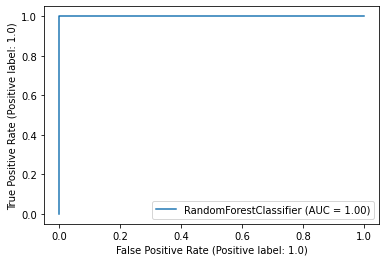

/home/bulbul/Documents/competition/signate_cup_2024/.venv/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.9140154772141015 0.9140154772141015


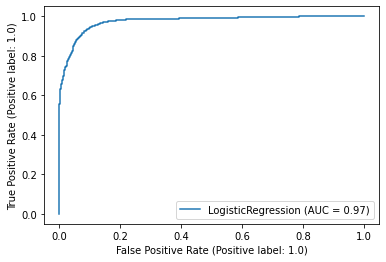

In [158]:
check_train_test(train_df, test_df)

In [168]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

target = train["ProdTaken"]

models = []
val_scores = []

for i, (train_index, valid_index) in enumerate(skf.split(train_df, target)):
    

    X_train, X_valid, y_train, y_valid = train_df.loc[train_index], train_df.loc[valid_index], target.loc[train_index], target.loc[valid_index]
    model = RandomForestClassifier(random_state=42)
#     model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)
    models.append(model)
    
    train_pred = model.predict_proba(X_train)
    train_score = roc_auc_score(y_train, train_pred[:, 1])
    
    pred = model.predict_proba(X_valid)
    val_score = roc_auc_score(y_valid, pred[:, 1])

    val_scores.append(val_score)
    
    print(f"Fold {i}: train score {train_score} val score: {val_score}")
    
print("val score (avg)", np.mean(val_scores))

Fold 0: train score 1.0 val score: 0.8019314381270903
Fold 1: train score 1.0 val score: 0.8255267558528429
Fold 2: train score 1.0 val score: 0.7872801470464241
Fold 3: train score 1.0 val score: 0.8191683108210654
Fold 4: train score 1.0 val score: 0.784804567413263
val score (avg) 0.8037422438521371


In [160]:
# basic modelling
# from sklearn.model_selection import train_test_split
# target = train["ProdTaken"]
# X_train, X_valid, y_train, y_valid = train_test_split(train_df, target, random_state = 42)
# print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

# model = RandomForestClassifier(random_state=42)
# model = LogisticRegression(random_state=42)
# model.fit() で学習します。訓練データと訓練データの目的変数を指定します。
# model.fit(X_train, y_train)
# pred = model.predict_proba(X_valid)
# score = roc_auc_score(y_valid, pred[:, 1])
# print(score)


# from sklearn.metrics import roc_curve
# fpr, tpr, thresholds = roc_curve(y_valid, pred[:, 1])

# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr,tpr,label='LogisticRegression')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.show()

In [161]:
# submission
predict = np.zeros((len(test_df), 2))
for model in models:
    predict += model.predict_proba(test_df)
predict = predict/5

submit = pd.read_csv("../data/sample_submit.csv", header=None)
submit.head()

,0,1
0,3489,0.119451
1,3490,0.343575
2,3491,0.119451
3,3492,0.119451
4,3493,0.119451


In [162]:
submit[1] = predict[:, 1]

In [163]:
submit.to_csv("submission.csv", index=False, header=None)

In [164]:
submit

,0,1
0,3489,0.202
1,3490,0.236
2,3491,0.420
3,3492,0.416
4,3493,0.250
...,...,...
3484,6973,0.244
3485,6974,0.056
3486,6975,0.682
3487,6976,0.428


In [165]:
sum(submit.loc[:, 1]> .5)

136

In [166]:
target.value_counts()

0    2992
1     497
Name: ProdTaken, dtype: int64